<a href="https://colab.research.google.com/github/KGF2/DeepLearningAmateur/blob/master/ToVerilog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as T


Bird's eye view of the project :

  1) Prepare the data

  2) Build the model

  3) Train the model
  
  4) Analyze the model's result

In [0]:
# 1) Prepare the data

# Data preprocessing
# ETL task : Extract, Transform and Load the data

train_set = torchvision.datasets.FashionMNIST( # train_set - dataset variable (it is an instance of FashionMNIST class that is inside torchvision package)
    # raw data EXTRACT
    root = './data:FashionMNIST',
    train = True,
    download = True,
    # raw image data TRANSFORM to tensor
    transform = T.Compose([T.ToTensor()])  
)

In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100) # training set was LOADED into dataloader, giving access to the data., # train_loader - data loader variable

In [0]:
import numpy as np

In [0]:
len(train_set)
torch.set_printoptions(linewidth=120)
train_set.data.shape


torch.Size([60000, 28, 28])

In [0]:
train_loader.batch_size

100

In [0]:
train_set.targets.bincount() # since all are equal, this dataset is called balanced dataset (else it is called unbalanced dataset [class imbalance] - oversampling is the best method to increase the samples of the lesser set)
# . since each lable/target has equal no of samples ie 60000 

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [0]:
sample = next(iter(train_set)) # to access indiv elements from trainset object
len(sample) # dataset contains image lable pairs. sample is a tuple.


In [0]:
image, label = sample # sequence unpacking/list unpacking.. replacement of {image = sample[0], label = sample[1]}
print(image.shape)
type(image)

torch.Size([1, 28, 28])


torch.Tensor

In [0]:
print(label)
type(label)

9


int

torch.Size([28, 28])
label 9


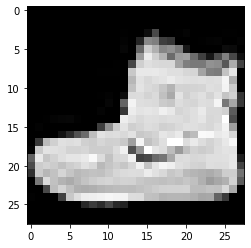

In [0]:
import matplotlib.pyplot as plt
print(image.squeeze().size())
plt.imshow(image.squeeze(), cmap='gray') # squeeze is used to remove 1D enteries from the shape of an array
print("label",label)

In [0]:
batch = next(iter(train_loader)) # similar to sample above
images, labels = batch
images.shape # dimention (B X C X H X W)

torch.Size([100, 1, 28, 28])

torch.Size([3, 302, 302])
labels tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5,
        2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1, 6, 3,
        1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8])


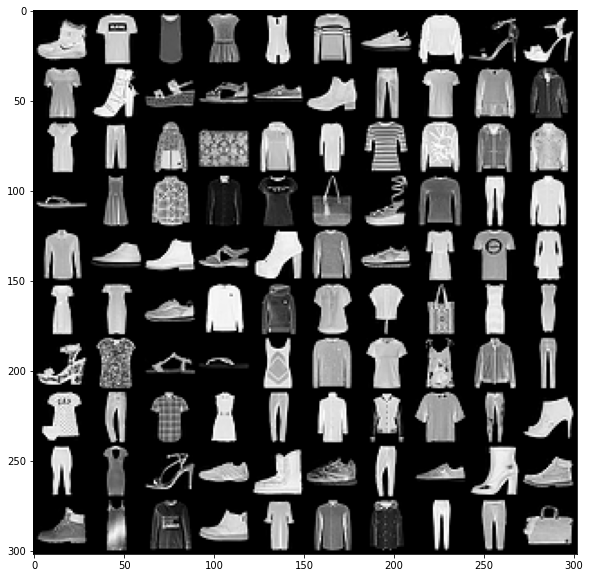

In [0]:
# print images in a batch

grid = torchvision.utils.make_grid(images, nrow=10) # creating a grid
plt.figure(figsize=(10,10))
print(grid.shape)
plt.imshow(np.transpose(grid, (1,2,0)))
print("labels", labels)

In [0]:
# 2) Build the model

import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    # 1 ip channel will be convolved by 6 diff filters which will create 6 output channels
    # in_channel is dependent on no. of color channels present inside the images. here, gray scale. hence 1
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) # in_channel, out_channel etc -> parameters (place holder); 1,6 etc -> arguments (values)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5) # kernel --> filter
    # out_channels, kernel_size, out_features are hyperparemeters - whose values are chosen manually and arbitrarily.. the rest are data-dependent hyperparameters.
    # weights present inside each conv layer (network.conv1.weight) of the network also the bias are learnable parameters - values which gets updated as the nw learns when loss functions are minimized.
    # out_channels -> feature maps
    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # 4*4 are height and width of input layers (starting from 28*28, reduced to 4*4 due to 2 conv layers before them)
    # in_features will be multiplied by weight matrics already present in the network network.fc1.weight.shape to generate out_features
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10) # out_features depend on the no.of classes/classification present in the training set ie 10 (trouser, pullover etc)
  
  def forward(self, t): # fowrard propagation
    # input layer
    t = t # not required, since implicit in pytorch. this layer converts tensor t to identity matrix. => tensor dim : [1,1,28,28]
    # hidden conv 1 layer
    t = self.conv1(t) # => dim : [1,6,24,24]
    t = F.relu(t) 
    t = F.max_pool2d(t, kernel_size=2, stride=2) # => dim : [1,6,12,12]
    # hidden conv 2 layer
    t = self.conv2(t) # => dim : [1,12,8,8]
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2) # => dim : [1,12,4,4]
    # hidden dense/full layer 1
    t = t.reshape(-1, 12*4*4) # => dim : [1,192]
    t = self.fc1(t)
    t = F.relu(t)
    # HDL 2
    t = self.fc2(t)
    t = F.relu(t)
    # output
    t = self.out(t)

    return t

In [0]:
# to check conv and max_pool functionality and dimensions
# output dimension (conv, maxpool) is calculated as [ (n - f + 2p) / s ] + 1 for input nXn, filter fXf, padding p, stride s
"""
input = torch.randn(1, 1, 28, 28)
# m = F.max_pool2d(input, kernel_size=6, stride=3, padding=2, dilation=1)
m = F.max_pool2d(input, kernel_size=2, stride=2) # dimension : 28-2/2 +1 = 7  = 14
m1 = F.max_pool2d(m, kernel_size=2, stride=2) # dim : 14-2/2 +1 = 7 
# Input: (N,C,Hin,Win)
# Output: (N,C,Hout,Wout) where 
print(input.shape)
print(m.shape)
print(m1.shape)
"""

'\ninput = torch.randn(1, 1, 28, 28)\n# m = F.max_pool2d(input, kernel_size=6, stride=3, padding=2, dilation=1)\nm = F.max_pool2d(input, kernel_size=2, stride=2) # dimension : 28-2/2 +1 = 7  = 14\nm1 = F.max_pool2d(m, kernel_size=2, stride=2) # dim : 14-2/2 +1 = 7 \n# Input: (N,C,Hin,Win)\n# Output: (N,C,Hout,Wout) where \nprint(input.shape)\nprint(m.shape)\nprint(m1.shape)\n'

In [0]:
"""network = Network() # instance of our network
print(network.conv1.weight.shape) # prints the rank 4 tensor with [out_channel, input_channel, kernel_height, kernel_width]
# means one color channel(input channel/depth of the filter) is convolved by 6 filters of 5x5 size. 
print(network.conv2.weight.shape)
print(network.conv2.weight[0].shape) # gives tensor for a single filter.
print("fc1", network.fc1.weight.shape)
print("fc2", network.fc2.weight.shape)
print("out", network.out.weight.shape)
print(network.conv1.weight) # learnable parameters
# in conv layers, weight values live inside the kernels/filters. the conv opern is an opern between input channel to the layer and the filter inside the layer. 
network
"""

'network = Network() # instance of our network\nprint(network.conv1.weight.shape) # prints the rank 4 tensor with [out_channel, input_channel, kernel_height, kernel_width]\n# means one color channel(input channel/depth of the filter) is convolved by 6 filters of 5x5 size. \nprint(network.conv2.weight.shape)\nprint(network.conv2.weight[0].shape) # gives tensor for a single filter.\nprint("fc1", network.fc1.weight.shape)\nprint("fc2", network.fc2.weight.shape)\nprint("out", network.out.weight.shape)\nprint(network.conv1.weight) # learnable parameters\n# in conv layers, weight values live inside the kernels/filters. the conv opern is an opern between input channel to the layer and the filter inside the layer. \nnetwork\n'

In [0]:
torch.set_grad_enabled(False) # disable computation graph feature used to calculate gradiend and hence loss function. we will turn this on when we do training

In [0]:
# passing an image to the network and interpreting the output
"""
network = Network()
print(image.shape) # 3D[C,H,W] image
print(image.unsqueeze(dim=0).shape) # to convert 3D[C,H,W] image to 4D image batch [B,C,H,W]
pred = network(image.unsqueeze(dim=0)) # nw has returned a prediction tensor whih contains the prediction value for 10 categories of clothing
print(pred)
print(pred.shape) # a tensor with no.of input images X no of prediction classes(10)
print(label)
print(pred.argmax(dim=1))
pred = F.softmax(pred, dim=1) # to give probalities, instead of values for the output classes
print(pred)
#F.softmax(pred, dim=1).sum() # shows the total prob sum is 1
print(pred.argmax(dim=1))
"""

'\nnetwork = Network()\nprint(image.shape) # 3D[C,H,W] image\nprint(image.unsqueeze(dim=0).shape) # to convert 3D[C,H,W] image to 4D image batch [B,C,H,W]\npred = network(image.unsqueeze(dim=0)) # nw has returned a prediction tensor whih contains the prediction value for 10 categories of clothing\nprint(pred)\nprint(pred.shape) # a tensor with no.of input images X no of prediction classes(10)\nprint(label)\nprint(pred.argmax(dim=1))\npred = F.softmax(pred, dim=1) # to give probalities, instead of values for the output classes\nprint(pred)\n#F.softmax(pred, dim=1).sum() # shows the total prob sum is 1\nprint(pred.argmax(dim=1))\n'

In [0]:
# passing batch of tensor ips to the nw and interpreting the output

network = Network()
preds = network(images)
#preds = F.softmax(preds) # in case if propabilities are required instead of values
preds.shape # batch size X output feature classes indexes
#print(preds)
#print(labels)
preds.argmax(dim=1) # for each of th images in batch, we are finding the prediction class index that has the higheest value

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [0]:
# function to get tot no of correct predictions
def get_num_correct_preds(preds, labels):
  # preds.argmax(dim=1).eq(labels) # labels of correct predictions
  return preds.argmax(dim=1).eq(labels).sum().item() # total no of correct predictions 

In [0]:
get_num_correct_preds(preds, labels)

11

In [0]:
# reshaping example
"""
t = torch.tensor([[[1,2,3],[3,2,1], [7,8,9]]])
print(t.shape)
print(t.reshape(-1, 9).shape)
"""

'\nt = torch.tensor([[[1,2,3],[3,2,1], [7,8,9]]])\nprint(t.shape)\nprint(t.reshape(-1, 9).shape)\n'

In [0]:
# 2) Train the model

# training with a single batch
"""
import torch.optim as optim

torch.set_grad_enabled(True) # gradient tracking is enables

preds = network(images)
print(preds.shape)
loss = F.cross_entropy(preds, labels) # calculating the loss. a tensor is returned
loss.item()
#print(loss)
loss.backward() # calculates gradient
print(network.conv1.weight.grad.shape)

# updating the weights

optimizer = optim.Adam(network.parameters(), lr=0.01)
loss.item()
print(get_num_correct_preds(preds, labels))
optimizer.step() # perform a single optimization step.. updates the weight
preds=network(images)
loss = F.cross_entropy(preds, labels)
loss.item()
loss.backward()
get_num_correct_preds(preds, labels)
preds=network(images)
loss = F.cross_entropy(preds, labels)
print(loss.item())
get_num_correct_preds(preds, labels)
optimizer.step()
preds=network(images)
loss = F.cross_entropy(preds, labels)
print(loss.item())
get_num_correct_preds(preds, labels)
"""

'\nimport torch.optim as optim\n\ntorch.set_grad_enabled(True) # gradient tracking is enables\n\npreds = network(images)\nprint(preds.shape)\nloss = F.cross_entropy(preds, labels) # calculating the loss. a tensor is returned\nloss.item()\n#print(loss)\nloss.backward() # calculates gradient\nprint(network.conv1.weight.grad.shape)\n\n# updating the weights\n\noptimizer = optim.Adam(network.parameters(), lr=0.01)\nloss.item()\nprint(get_num_correct_preds(preds, labels))\noptimizer.step() # perform a single optimization step.. updates the weight\npreds=network(images)\nloss = F.cross_entropy(preds, labels)\nloss.item()\nloss.backward()\nget_num_correct_preds(preds, labels)\npreds=network(images)\nloss = F.cross_entropy(preds, labels)\nprint(loss.item())\nget_num_correct_preds(preds, labels)\noptimizer.step()\npreds=network(images)\nloss = F.cross_entropy(preds, labels)\nprint(loss.item())\nget_num_correct_preds(preds, labels)\n'

In [0]:
a = torch.tensor([1,1,1,1])
b = torch.tensor([2,2,2,2])
c = torch.tensor([3,3,3,3])
torch.cat((a,b,c), dim=0)
torch.stack((a,b,c), dim=0)
## ??np.stack VVIP


In [0]:
from torch.utils.tensorboard import SummaryWriter